In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
import torch
import numpy as np
from mirtorch.alg import CG, FISTA, POGM, power_iter, FBPD
from mirtorch.linear import LinearMap, FFTCn, NuSense, Sense, FFTCn, Identity, Diff2dgram, Diff3dgram, Gmri, Wavelet2D, Diffnd
from mirtorch.prox import Prox, L1Regularizer, Const
import matplotlib.pyplot as plt
import copy
import h5py
import torchkbnufft as tkbn
import time
%load_ext autoreload
%autoreload 2

## Compressed sensing example
This example shows the MR reconstruction with compressed sensing. The cost function is $\textit{argmin}_{x} \|Ax-y\|_2^2 + \lambda \|Tx\|_1$, where $T$ typically is a wavelet transform or total variation operator.

ex_multi### Simulate the data 

In [3]:
# Load the data
ex_multi = np.load('AXT2_210_6001736_layer11.npz')
device0 = torch.device('cpu')
# k-space
k_c = torch.tensor(ex_multi['k_r'] + 1j*ex_multi['k_i']).to(device0)/32767.0
# Sense map
s_c = torch.tensor(ex_multi['s_r'] + 1j*ex_multi['s_i']).to(device0)/32767.0
# Define Sense operator
(nc, nh, nw) = s_c.shape
Fop = FFTCn((nc, nh, nw), (nc, nh, nw), (1,2), norm = 'ortho')
# Coil-wise iFFT reconstruction and central crop
I1 = (Fop.H*k_c).to(torch.complex64).unsqueeze(0)
nx = 320
ny = 320
I1 = I1[:,:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2]
s_c = s_c[:,nh//2-nx//2:nh//2+nx//2,nw//2-ny//2:nw//2+ny//2].unsqueeze(0).to(torch.complex64)
mask = torch.zeros(nx,ny)
mask[:,0:ny:4]=1
mask[:,140:180]=1
# simulate the cropped k-space
Fop = FFTCn((1, nc, nx, ny), (1, nc, nx, ny), (2,3), norm = 'ortho')
K1 = Fop*I1
# A'y
Sop = Sense(s_c, mask.unsqueeze(0))
I0 = Sop.H*K1
# Ground truth
Sop_full = Sense(s_c, torch.ones_like(mask.unsqueeze(0)))
I_gt = Sop_full.H*K1

In [8]:
mask.dtype

torch.float32

In [3]:
# Define the wavelet operator
W = Wavelet2D(I0.shape, padding='periodization', J=2, wave_type = 'db4')

In [4]:
# Calculate the step size with power iteration (Lipschitz)
L = power_iter(Sop, torch.randn_like(I0), max_iter=200)

The calculation of max singular value accomplished at 62 iterations.
The spectral norm is 0.9997735619544983.


In [5]:
# Define the proximal operator
wv_weights = 1e-5
P = L1Regularizer(wv_weights, T = W)

In [6]:
# Define the gradient
def gradA(x):
    return Sop.H*Sop*x-I0

# Record the curve of loss function
def evalation(x):
    return (torch.norm(Sop*x-K1)**2).item()+wv_weights*torch.norm(P(x,1), p=1).item()

In [7]:
# POGM
start = time.time()
[pg_wavelet, loss_pg_wavelet] = POGM(f_grad=gradA, f_L=L[1].item()**2, g_prox=P, max_iter=100, eval_func=evalation).run(x0=I0)
print('running time %f s'%(time.time()-start))

running time 11.627530 s


In [8]:
start = time.time()
[fs_wavelet, loss_fs_wavelet] = FISTA(f_grad=gradA, f_L=L[1].item()**2, g_prox=P, max_iter=100, eval_func=evalation).run(x0=I0)
print('running time %f s'%(time.time()-start))

running time 11.513873 s


In [9]:
f_prox = Const()
start = time.time()
[fbpd_wavelet, loss_fbpd_wavelet] = FBPD(gradA, f_prox, P, L[1].item()**2, 1, G=W, max_iter=200, eval_func=evalation).run(torch.zeros_like(I0))
print('running time %f s'%(time.time()-start))

running time 28.001954 s


### Total variation reconstruction

In [10]:
TV_weight = 1e-4
T = Diffnd(I0.shape, [2,3])
P1 = L1Regularizer(TV_weight)
def evalation(x):
    return (torch.norm(Sop*x-K1)**2).item()+TV_weight*torch.norm(T*x, p=1).item()
f_prox = Const()
start = time.time()
[fbpd_tv, loss_fbpd_tv] = FBPD(gradA, f_prox, P1, L[1].item()**2, 8, G=T, max_iter=200, eval_func=evalation).run(I0)
print('running time %f s'%(time.time()-start))

running time 16.864136 s


Text(0.5, 1.0, 'FISTA-Wavelets Recon')

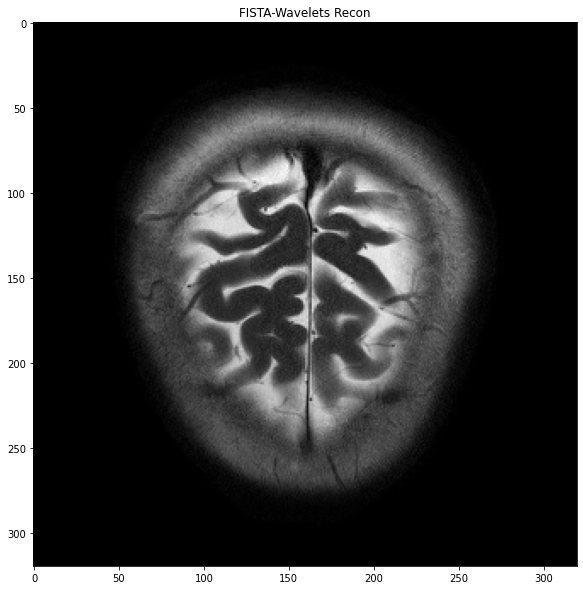

In [11]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fs_wavelet[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FISTA-Wavelets Recon')

Text(0.5, 1.0, 'POGM-Wavelets recon')

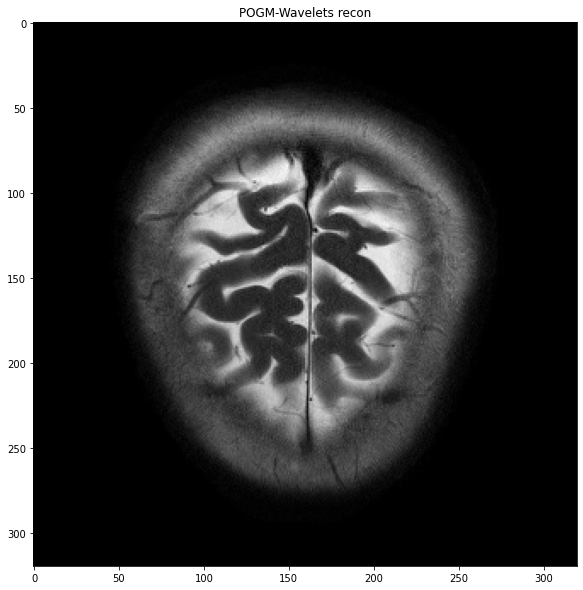

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(torch.abs((pg_wavelet[0,0,:,:])).cpu().data.numpy(),cmap='gray')
plt.title('POGM-Wavelets recon')

Text(0.5, 1.0, 'FBPD-Wavelets Recon')

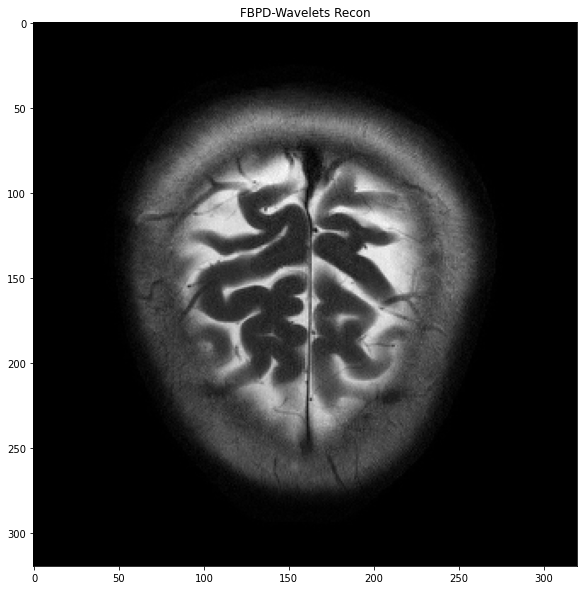

In [13]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fbpd_wavelet[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FBPD-Wavelets Recon')

Text(0.5, 1.0, 'FBPD-TV Recon')

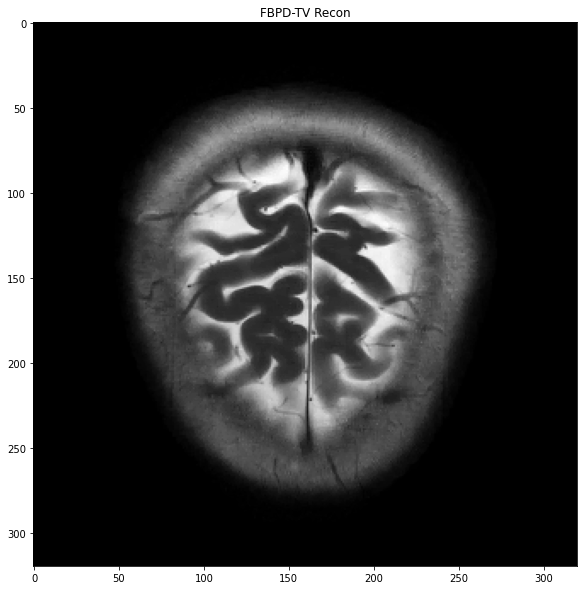

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fbpd_tv[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FBPD-TV Recon')

Text(0.5, 1.0, 'FBPD-TV Recon')

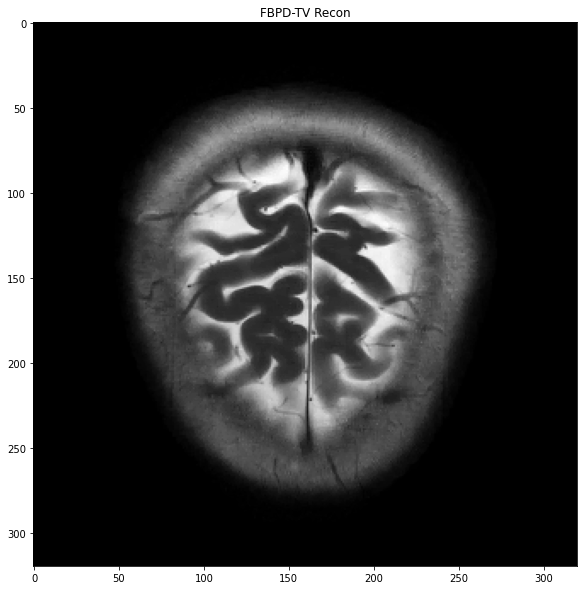

In [15]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((fbpd_tv[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('FBPD-TV Recon')

Text(0.5, 1.0, 'Fully-sampled')

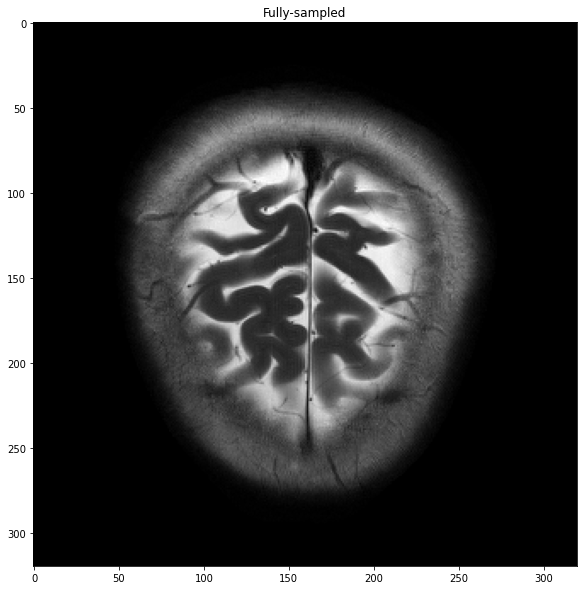

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(((torch.abs((I_gt[0,0,:,:])))).cpu().data.numpy(),cmap='gray')
plt.title('Fully-sampled')

In [ ]:
plt.plot(loss_fs_wavelet)

In [ ]:
plt.plot(loss_pg_wavelet)

In [ ]:
plt.plot(loss_fbpd_wavelet)

In [ ]:
plt.plot(loss_fbpd_tv)

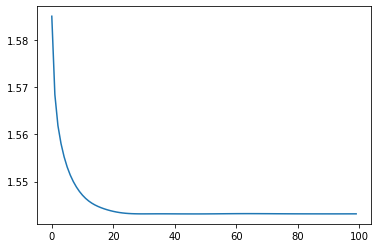

In [17]:
plt.plot(loss_fbpd_tv)

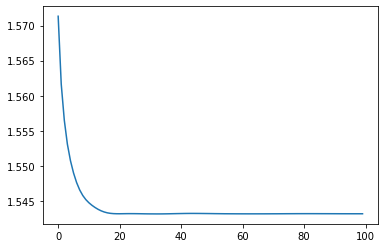

In [18]:
plt.plot(loss_pg_wavelet)

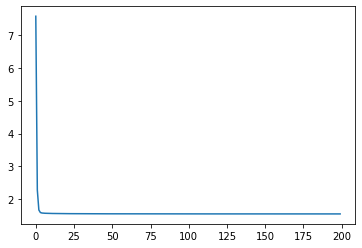

In [19]:
plt.plot(loss_fbpd_wavelet)

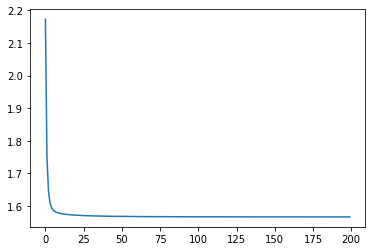

In [20]:
plt.plot(loss_fbpd_tv)